In [8]:
#imports
import igraph as ig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import random
from tqdm import tqdm
from decimal import Decimal
import networkx as nx


In [9]:
df = pd.read_excel("./manufacturing_emails_preprocessed.xlsx")

#preprocess data by removing duplicate rows (where node1, node2 and timestamp are the same) NOTE: was not duplicates in the dataset:
nonDuplicateDf = df.drop_duplicates(subset=['node1', 'node2', 'timestamp'])

#nonDuplicateDf = df.drop_duplicates(subset=['node1', 'node2'])
edges = nonDuplicateDf[["node1", "node2", "timestamp"]].to_numpy() #array with all arcs, each row is an arc, with first column being origin node, second column is destination node
numberOfVertices = len(np.unique(edges[:, :2])) #number of vertices = the number of unique value in the two first columns of th eexcel sheet
g = ig.Graph(numberOfVertices, edges[:, :2])  #for edges, use all rows, but only two first columns (ignore timestamp)





In [10]:
infoSpreadDf = df.copy(deep = True) #separate df to find info spread
infoSpreadNpArray = df.to_numpy()


In [5]:
#Task 8: helper code for info spreading (shitty version)
def getNewInfectedNodesAtTimestep(fromNode, timestamp):
    """get all nodes a node would infect at a specific timestamp"""
    #these two lines get all nodes that the fromNode has an arc to, at timestep timestamp. Have to do it for both node1 col and node2 col since links are undirected
    fromNode1 = infoSpreadDf.loc[(infoSpreadDf['node1'] == fromNode) & (infoSpreadDf["timestamp"] == timestamp)]["node2"].to_numpy()
    fromNode2 = infoSpreadDf.loc[(infoSpreadDf['node2'] == fromNode) & (infoSpreadDf["timestamp"] == timestamp)]["node1"].to_numpy()

    newInfectedNodes = np.unique(np.concatenate((fromNode1,fromNode2), axis=0))
    return newInfectedNodes

def getNewInfectedNodesAtTimestepWithNumpy(fromNode, timestamp, fromIndex, lengthOfArr = 82281):
    """get all nodes a node would infect at a specific timestamp. Returns the new infected nodes, as well as the new index to start looking from"""
    #these two lines get all nodes that the fromNode has an arc to, at timestep timestamp. Have to do it for both node1 col and node2 col since links are undirected
    res = set()
    for i in range(fromIndex, lengthOfArr):
        row = infoSpreadNpArray[i] #first element is node1, second is node2, third is node3
        if (row[2] != timestamp):
            break #can just break if not correct timestamp, since the timestamp col is sorted
        if (row[0] == fromNode):
            res.add(row[1])
        if (row[1] == fromNode):
            res.add(row[0])

    return res, i


In [51]:
#Task 8: Part B: Information spreading on a temporal network (shitty version)
infoSpreadNpArray = df.to_numpy()

numInfectedNodesForAllIterations = [] # = I(t) = 2d list that contains the number of infected nodes at each timestep (timestep is index here) for each iteration 

T = 57791 #= number of nodes = max(nonDuplicateDf["timestamp"].to_numpy())
N = 167 # = number of simulations to do = number of nodes
for i in range(1, N+1):	 #each simulation
	infoSpreadNpArray = df.to_numpy()
	currIdx = 0 #index to fast lookup the infoSpreadNpArray

	initialInfectedNode = i 
	infectedNodes = {initialInfectedNode} #currently infected nodes (store as set since it only needs unique values)
	numInfectedNodes = [1] #always start with 1 infected node at timestep 0

	for j in tqdm(range(1, T+1)): 
		newInfectedNodes = set() 
		for infectedNode in infectedNodes:
			newNodes, newIdx = getNewInfectedNodesAtTimestepWithNumpy(infectedNode, j, currIdx)
			newInfectedNodes.update(newNodes)
		currIdx = newIdx #update index so we don't have to go through all elements again
		
		infectedNodes.update(newInfectedNodes) #add list of newly infected nodes to set, if duplicate, it is removed since it is a set

		numInfectedNodes.append(len(infectedNodes))
	numInfectedNodesForAllIterations.append(numInfectedNodes)

100%|█████████▉| 57661/57791 [00:18<00:00, 3050.76it/s]


KeyboardInterrupt: 

In [ ]:
#Task 9 slow version:
#load array 
numInfectedNodesForAllIterations = np.loadtxt("taskBRemote.txt")

#Task 9: Get the average of number of infected nodes over all iteration
averageNumberOfInfectedNodes = np.average(numInfectedNodesForAllIterations, axis=0) #average over all iterations (so we get the average at each timestep)
#print("Average number of infected nodes per timestep for all N iterations: ", averageNumberOfInfectedNodes)
#get the standard deviation
standardDeviationOfNumberOfInfectedNodes = np.std(numInfectedNodesForAllIterations, axis=0)
#print("Standard deviation of infected nodes per timestep for all N iterations: ", standardDeviationOfNumberOfInfectedNodes)

#now plot the two arrays (that have N elements each)
x = [i for i in range(1, 57792+1)] #x axis is each timestep

#plot
plt.plot(x,averageNumberOfInfectedNodes, color= "red", label="Average")
plt.errorbar(x,averageNumberOfInfectedNodes, yerr = standardDeviationOfNumberOfInfectedNodes, label="Standard deviation of average", alpha=0.005, color="grey")
#plt.plot(x,standardDeviationOfNumberOfInfectedNodes, color= "red", label="Standard deviation")
plt.xlabel("Timestep")
plt.ylabel("Infected nodes")
plt.title("Plot of average and standard deviation of infected nodes per timestep")
plt.legend()
plt.show()


100%|██████████| 167/167 [00:26<00:00,  6.19it/s]


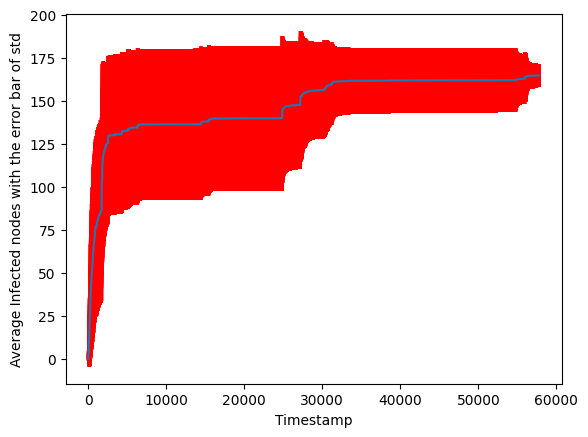

In [117]:
#Task 8 and 9 - fast version

num_vertices=167
dfNpArr = df.to_numpy()
T = range(57792)

T = range(57792)
yNp = list(np.zeros((57792, num_vertices)))
for first_infected_node in tqdm(range(1,num_vertices+1)):
    infected= {first_infected_node}

    currTimestep = 1
    currTimestepInfected = set()
    
    for row in dfNpArr:
        if (row[2] > currTimestep):
            currTimestep = row[2]
            infected.update(currTimestepInfected)
            currTimestepInfected = set()

        if row[0] in infected and row[1] not in infected:
            currTimestepInfected.add(row[1])
        if row[1] in infected and row[0] not in infected:
            currTimestepInfected.add(row[0])
            
        #print(row['timestamp'])
        yNp[row[2]][first_infected_node-1]=len(infected)
    
yNp = np.array(yNp)
average_infection=yNp.mean(axis=1)
std_infection=yNp.std(axis=1)

#x = [i for i in range(1, 57792+1)] #x axis is each timestep

plt.figure(1)
plt.errorbar(T,average_infection,yerr=std_infection, ecolor='r')
plt.xlabel('Timestamp')
plt.ylabel('Average Infected nodes with the error bar of std')
plt.savefig('task9.eps', format='eps')

plt.show()

np.savetxt("Task9.txt", y)



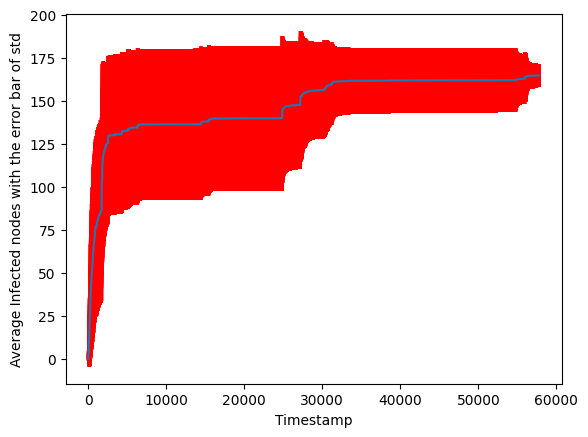

In [118]:
plt.figure(1)
plt.errorbar(T,average_infection,std_infection, ecolor='r')
plt.xlabel('Timestamp')
plt.ylabel('Average Infected nodes with the error bar of std')
plt.savefig('task9.eps', format='eps')

plt.show()

np.savetxt("Task9.txt", y)



In [65]:
#Testing task 10 with copiedCode, NOTE: looks correct, only numbers are 1 bigger than what I got (prob because node id 0 does not exist thingy)
nodeInfluences = [] #list for each of the 167 nodes, how long it took to infect >= 70% of the nodes = 116.9  = 117. So atleast 117 of the nodes need to be infected
 
for idx, node in enumerate(yNp.T):
	added = False
	for i in range(len(node)):
		if (node[i] >= 117):
			nodeInfluences.append((idx+1, i)) #idx is the id of the node
			added = True
			break
	if (not added):
		nodeInfluences.append((idx+1, i)) # never got 70 percent of nodes

#nodeInfluences[-20:]

[  0.   1.  17. ... 167. 167. 167.]


In [182]:
#Task 10: Find influence of nodes (how long it takes to infect 70% of graph)
nodeInfluences = [] #list for each of the 167 nodes, how long it took to infect >= 70% of the nodes = 116.9  = 117. So atleast 117 of the nodes need to be infected

for idx, node in enumerate(yNp.T):
	added = False
	a = len(node)
	for i in range(len(node)):
		if (node[i] >= 117):
			nodeInfluences.append((idx+1, i)) #idx is the id of the node, i is the timestep
			added = True
			break

nodeInfluences.sort(key=lambda x: x[1], reverse=False) #sort list my time it took to infect 70 percent of nodes, still have node id to know which node is which
#NOTE: sorted ascending, because the lower times it takes to infect many nodes, the more influential a node is


In [145]:
#Task 11: 

#import the data and make aggregated graph:
df = pd.read_excel("./manufacturing_emails_preprocessed.xlsx")
nonDuplicateDf = df.drop_duplicates(subset=['node1', 'node2']) #aggregated network, ignore same node pairs for differnet timesteps
edges = nonDuplicateDf[["node1", "node2", "timestamp"]].to_numpy() #array with all arcs, each row is an arc, with first column being origin node, second column is destination node
numberOfVertices = len(np.unique(edges[:, :2])) #number of vertices = the number of unique value in the two first columns of th eexcel sheet
g = ig.Graph(numberOfVertices, edges[:, :2])  #for edges, use all rows, but only two first columns (ignore timestamp)

#non aggregated df (keep node pairs with different timestamps): #this includes aggreating 1,2 and 2,1 for example (from and to node does not matter)
groupedDf = df.groupby(["node1", "node2"])["timestamp"].apply(list).reset_index(name="weight")
for i in range(len(groupedDf)):
    arr = groupedDf.iloc[i]["weight"]
    groupedDf.at[i,'weight'] = len(arr)

In [146]:
#degree of aggregated network
degreeArr = g.degree()[1:] #ignore first node, since igraph is 0 indexed, but we start node id at 1, then first element in this array is 0

degreeArrWithIndices = []
for i in range(len(degreeArr)):
	degreeArrWithIndices.append((i+1, degreeArr[i]))
degreeArrWithIndices.sort(key=lambda x: x[1], reverse=True) #sort according to degree descending

#compute strength of each node (weights of links found in task 8)

strengthOfNodes = [] #array that contains strength of all 167 nodes
groupedDfNpArr = groupedDf.to_numpy()
for nodeIdx in tqdm(range(1, 167+1)):
	sumForNode = 0
	for i in range(len(groupedDf)):
		if (groupedDfNpArr[i][0] == nodeIdx or groupedDfNpArr[i][1] == nodeIdx):
			sumForNode += groupedDfNpArr[i][2]
	strengthOfNodes.append((nodeIdx, sumForNode))

strengthOfNodes.sort(key=lambda x: x[1], reverse=True) #sort according to weight descending


100%|██████████| 167/167 [00:00<00:00, 535.19it/s]


In [147]:
R = nodeInfluences
D = degreeArrWithIndices
S = strengthOfNodes

In [148]:
def topFRecognitionRate(f, R, compareSet):
    """compareset can be strength, connectivity, ... other metrics you want to use, have to have an element for each node in graph"""
    Rf = getTopFPercentFromSet(R, f) #top f fraction of influence of nodes
    RfWithOnlyNodeId = (np.array(list(Rf))[:, 0]) #all rows, but just first column which contains the node id
    compareSetf = getTopFPercentFromSet(compareSet, f) #top f fraction of degree of nodes
    compareSetfWithOnlyNodeId = (np.array(list(compareSetf))[:, 0])
    return (len(set(RfWithOnlyNodeId).intersection(set(compareSetfWithOnlyNodeId)))/len(RfWithOnlyNodeId))

def getTopFPercentFromSet(setToRetrieveFrom, f):
    numberOfElements = int(Decimal(len(setToRetrieveFrom)*f).to_integral_value()) #NOTE round value up if 0.5 or larger, down else
    return (list(setToRetrieveFrom)[:numberOfElements])

r_rd = []
r_rs = []

fArray = np.arange(start=0.05, stop=0.5+1e-10, step=0.05) #stop at just above 0.5 to include 0.5
for f in fArray:
    r_rd.append(topFRecognitionRate(f, R, D))
    r_rs.append(topFRecognitionRate(f, R, S))


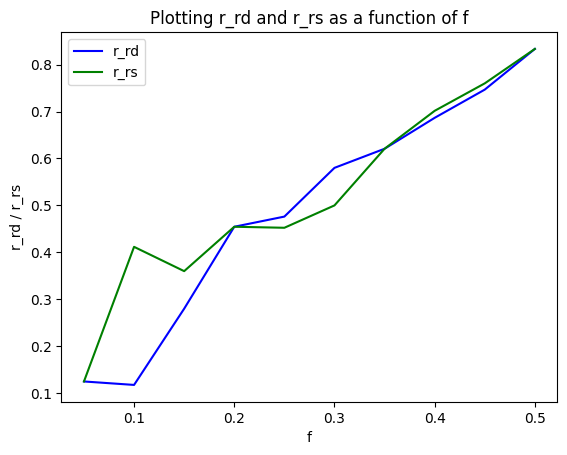

In [149]:
#plot the results, the f's are the x axis, and the calculated values are the y axis

plt.plot(fArray, r_rd, label="r_rd", color="blue")
plt.plot(fArray, r_rs, label="r_rs", color="green")
plt.title("Plotting r_rd and r_rs as a function of f")
plt.xlabel("f")
plt.ylabel("r_rd / r_rs")
plt.legend()
plt.show()

In [173]:
print(f"r_rd :  {np.sum(r_rd)}")
print(f"r_rs :  {np.sum(r_rs)}")

r_rd :  4.920639808910979
r_rs :  5.21920663862794


#NOTE: I think higher value is better, since then it has more overlap with the influence, therefore: r_rs better (look like, could also do integral)


In [136]:
#Task 12 two other to features to predict nodes influence

#make aggregated network:
df = pd.read_excel("./manufacturing_emails_preprocessed.xlsx")
df = df.drop_duplicates(subset=['node1', 'node2']) #aggregate by just removing all duplicates of node edges
edges = df[["node1", "node2", "timestamp"]].to_numpy() #array with all arcs, each row is an arc, with first column being origin node, second column is destination node
numberOfVertices = len(np.unique(edges[:, :2])) #number of vertices = the number of unique value in the two first columns of th eexcel sheet
g = ig.Graph(numberOfVertices, edges[:, :2])  #for edges, use all rows, but only two first columns (ignore timestamp)

#also make networkx graph to use certain metrics from networkx package
G = nx.Graph() 
G.add_edges_from(edges[:, :2])


In [150]:
# metric 1: centrality of aggregated network
loadCentrality = nx.load_centrality(G)
loadCentralityAndIndices = (list(loadCentrality.items())) #centrality is a dictionary so use items to grab both index and the centrality per node
loadCentralityAndIndices.sort(key=lambda x: x[1], reverse=True) #sort list my time it took to infect 70 percent of nodes, still have node id to know which node is which


In [138]:
#metric 2: average time between connections:
df = pd.read_excel("./manufacturing_emails_preprocessed.xlsx")

In [151]:
connectionTimestepsAllNodes = [] #for every node, contains a list of every timestep it had a connection
dfNpArr = df.to_numpy()
for i in tqdm(range(1, 167+1)): #for all node id's
    nodeConnectionTimesteps = set()
    for row in dfNpArr:
        if row[0] == i or row[1] == i:
            nodeConnectionTimesteps.add(row[2])
    connectionTimestepsAllNodes.append(sorted(list(nodeConnectionTimesteps)))

T = 57791 

def getAverageTimeBetweenConnections(timestamps):
    timestamps.insert(0, 0)
    timestamps.append(T) #add the final timestep
    diffs = np.diff(timestamps) #create new array with difference between each element (is equally long as timestamps since T is appended to it)
    return sum(diffs)/len(diffs)

averageTimeBetweenConnections = [] #for every node, store average time between connection

for i in tqdm(range(len(connectionTimestepsAllNodes))):
    averageTimeBetweenConnections.append(getAverageTimeBetweenConnections(connectionTimestepsAllNodes[i]))

100%|██████████| 167/167 [00:00<00:00, 6754.57it/s]


In [162]:
averageTimeBetweenConnectionsWithIndices = []
for i in range(len(averageTimeBetweenConnections)):
    averageTimeBetweenConnectionsWithIndices.append((i+1, averageTimeBetweenConnections[i]))
averageTimeBetweenConnectionsWithIndices.sort(key=lambda x: x[1], reverse=False) #sort list my time it took to infect 70 percent of nodes, still have node id to know which node is which
#reverse False, as low time between connection = more influential node

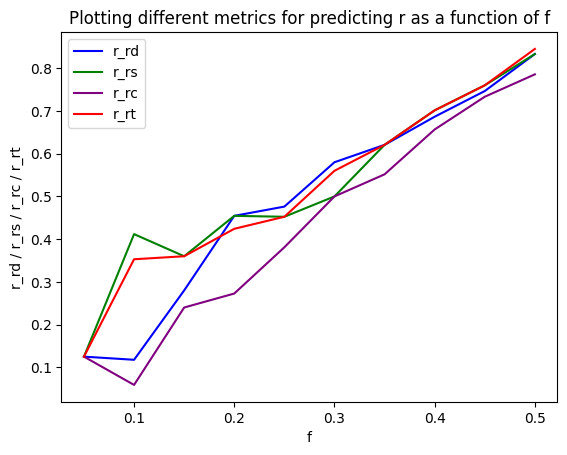

In [163]:
#Compare all 4 metrics to find out which best describes node influence
R = nodeInfluences
D = degreeArrWithIndices
S = strengthOfNodes
C = loadCentralityAndIndices
T = averageTimeBetweenConnectionsWithIndices

r_rd = []
r_rs = []
r_rc = []
r_rt = [] 

fArray = np.arange(start=0.05, stop=0.5+1e-10, step=0.05) #stop at just above 0.5 to include 0.5
for f in fArray:
    r_rd.append(topFRecognitionRate(f, R, D))
    r_rs.append(topFRecognitionRate(f, R, S))
    r_rc.append(topFRecognitionRate(f, R, C))
    r_rt.append(topFRecognitionRate(f, R, T))

#plot the results, the f's are the x axis, and the calculated values are the y axis

plt.plot(fArray, r_rd, label="r_rd", color="blue")
plt.plot(fArray, r_rs, label="r_rs", color="green")
plt.plot(fArray, r_rc, label="r_rc", color="purple")
plt.plot(fArray, r_rt, label="r_rt", color="red")
plt.title("Plotting different metrics for predicting r as a function of f")
plt.xlabel("f")
plt.ylabel("r_rd / r_rs / r_rc / r_rt")
plt.legend()
plt.show()

In [166]:
np.sum(r_rd)

4.920639808910979

In [174]:
print(f"r_rd : {np.sum(r_rd)}")
print(f"r_rs : {np.sum(r_rs)}")
print(f"r_rc : {np.sum(r_rc)}")
print(f"r_rt : {np.sum(r_rt)}")


r_rd : 4.920639808910979
r_rs : 5.21920663862794
r_rc : 4.304991357980519
r_rt : 5.201984840817906


In [186]:
#Task 13:

#find R_dash, which is similar to R, but instead of time to infect >= N*0.7 nodes, it is the average time used to infect nodes in the set N*0.7 nodes
R_dash = []  
T = 57791
# numInfectedNodesForAllIterations = np.loadtxt("taskBRemote.txt") #saved calculation in file for fast retrieval

for idx, node in enumerate(yNp.T): 
	totTime = 0
	for i in range(1, len(node)):
		totTime += (node[i] - node[i-1])*i #NOTE new line!
		if (node[i] >= 117):
			R_dash.append((idx+1, round(totTime/117, 1))) #NOTE: deler på en konstant her -> gjør jo ingen forskjell!!! 
			break


R_dash.sort(key=lambda x: x[1]) #sort list my time it took to infect 70 percent of nodes, still have node id to know which node is which

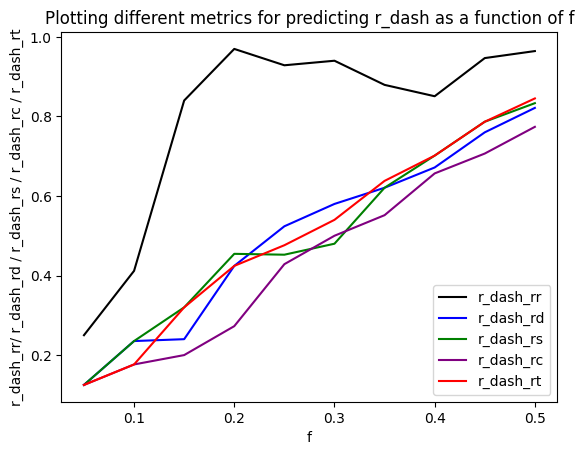

In [187]:
#Compare all 5 metrics to find out which best describes R_dash
R = nodeInfluences
D = degreeArrWithIndices
S = strengthOfNodes
C = loadCentralityAndIndices
T = averageTimeBetweenConnectionsWithIndices
R_DASH = R_dash

r_dash_rr = []
r_dash_rd = []
r_dash_rs = []
r_dash_rc = []
r_dash_rt = [] 

fArray = np.arange(start=0.05, stop=0.5+1e-10, step=0.05) #stop at just above 0.5 to include 0.5
for f in fArray:
    r_dash_rr.append(topFRecognitionRate(f, R_DASH, R))
    r_dash_rd.append(topFRecognitionRate(f, R_DASH, D))
    r_dash_rs.append(topFRecognitionRate(f, R_DASH, S))
    r_dash_rc.append(topFRecognitionRate(f, R_DASH, C))
    r_dash_rt.append(topFRecognitionRate(f, R_DASH, T))

#plot the results, the f's are the x axis, and the calculated values are the y axis

plt.plot(fArray, r_dash_rr, label="r_dash_rr", color="black")
plt.plot(fArray, r_dash_rd, label="r_dash_rd", color="blue")
plt.plot(fArray, r_dash_rs, label="r_dash_rs", color="green")
plt.plot(fArray, r_dash_rc, label="r_dash_rc", color="purple")
plt.plot(fArray, r_dash_rt, label="r_dash_rt", color="red")
plt.title("Plotting different metrics for predicting r_dash as a function of f")
plt.xlabel("f")
plt.ylabel("r_dash_rr/ r_dash_rd / r_dash_rs / r_dash_rc / r_dash_rt")
plt.legend()
plt.show()

In [188]:
print(f"r_dash_rr : {np.sum(r_dash_rr)}")
print(f"r_dash_rd : {np.sum(r_dash_rd)}")
print(f"r_dash_rs : {np.sum(r_dash_rs)}")
print(f"r_dash_rc : {np.sum(r_dash_rc)}")
print(f"r_dash_rt : {np.sum(r_dash_rt)}")


r_dash_rr : 7.981042098587434
r_dash_rd : 5.002106083344768
r_dash_rs : 5.009402717059312
r_dash_rc : 4.391686035851668
r_dash_rt : 5.033231822369148
